# Visualize $f/I$ curves for DRN SOM cells

Shown in fig. 1.

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-stable/src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd

from grr.cell_class import Cell
from grr.Trace import detectSpikes
from grr.Tools import stripNan
from grr.FrequencyInputCurve import FrequencyInputCurve
from ezephys.pltools import hide_border

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))
IMG_PATH = None

## Load data

First we'll just load the current step data.

In [4]:
DATA_PATH = os.path.join('data', 'raw', 'GABA', 'current_steps')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


**Drop JF's cells** since only one is usable and doesn't follow the same experimental protocol as the others. (2 cells with current channel not registered, one cell with current steps at a different time than my cells.)

In [5]:
fnames.drop(fnames.index[14:17], inplace = True)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


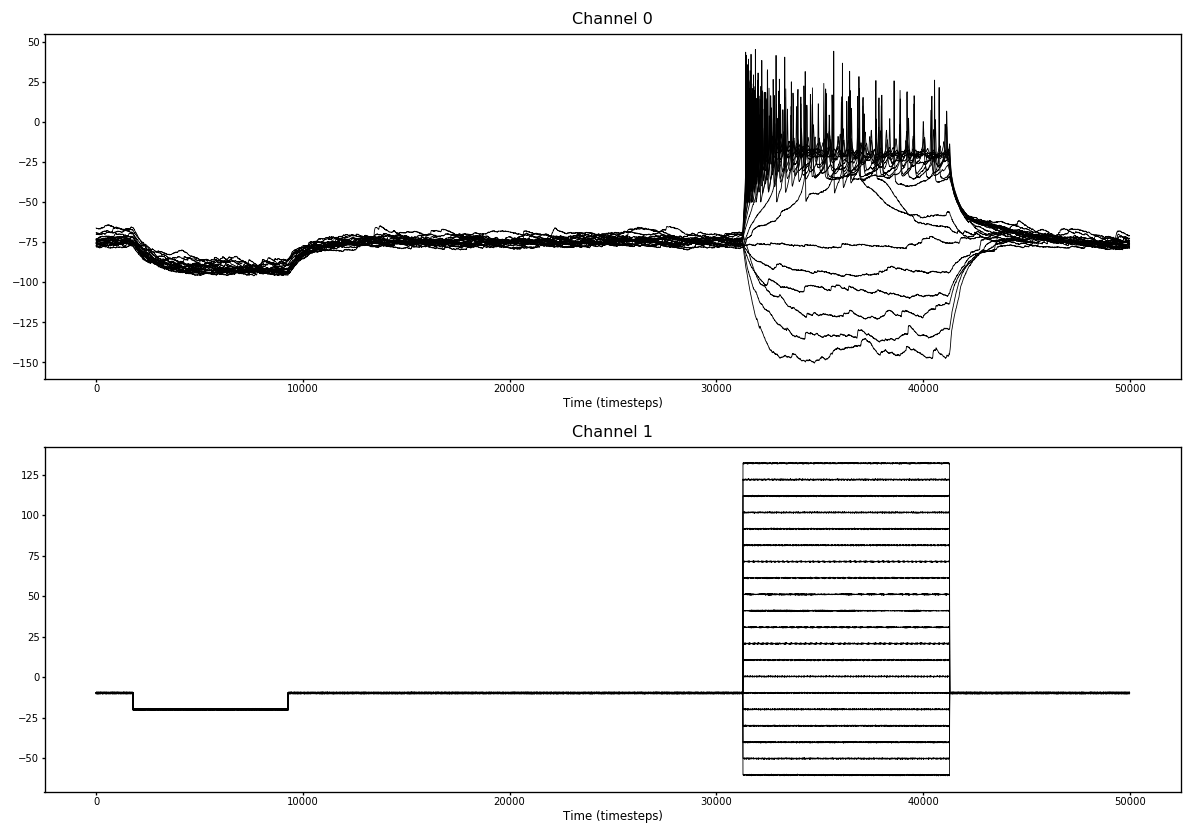

In [6]:
curr_steps = Cell().read_ABF([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
curr_steps[0].plot()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [7]:
change_threshold = 5. # pA threshold at which to detect a step.

tstpts = {}
mainpts = {}

try:
    tstpts['start'], mainpts['start'] = np.where(np.diff(curr_steps[0][1, :, 0]) < -change_threshold)[0]
    tstpts['stop'], mainpts['stop'] = np.where(np.diff(curr_steps[0][1, :, 0]) > change_threshold)[0]
except ValueError:
    print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
    raise

del change_threshold

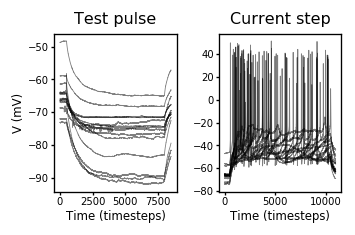

In [8]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for expt in curr_steps:
    tst_ax.plot(
        expt[0, (tstpts['start'] - buffer_timesteps):(tstpts['stop'] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'] - buffer_timesteps):(mainpts['stop'] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

Quality control. Remove experiments where $I$ channel wasn't registered correctly. Cells being rejected are plotted, and number of retained cells is printed at the end.

In [9]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

14 of 14 cells passed quality control.


## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [10]:
# Detect spikes in all recordings.
spktimes = [detectSpikes(rec[0, :, :], 0., 3., 0, 0.1) for rec in curr_steps]

In [11]:
fi_summarizer = FrequencyInputCurve(lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25))

fi_data = {metric: [] for metric in fi_summarizer.summary_metrics}
fi_summaries = []

for i, (rec, times) in enumerate(zip(curr_steps, spktimes)):
    fi_summarizer.fit(times, rec[1, ...], (mainpts['start'], mainpts['stop']), dt)
    
    fi_summaries.append(fi_summarizer.copy())
    
    for metric in fi_summarizer.summary_metrics:
        fi_data[metric].append(fi_summarizer.get_metric(metric))

fi_df = pd.DataFrame(fi_data)
fi_df.drop(columns=['CV', 'I', 'f'], inplace=True)
fi_df

/home/eharkin/miniconda3/envs/testpozz/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/eharkin/miniconda3/envs/testpozz/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


,freq_at_50,freq_at_rheobase,gain,is_monotonic,rheobase,spearman_p,spearman_rho
0,15.237535,6.0,-0.055545,False,0.508996,1.300312e-02,-0.643629
1,2.000000,8.0,-0.042513,False,-4.507909,1.191486e-02,-0.753123
2,7.881604,2.0,0.080639,True,0.505605,3.630412e-04,0.924402
3,4.831990,2.0,-0.059880,False,-12.489766,1.647161e-01,-0.475619
4,3.161935,2.0,0.156894,True,46.084441,6.646897e-64,1.000000
5,3.000000,2.0,0.061702,False,15.714457,1.353451e-03,0.861606
6,8.804591,3.0,0.218902,True,20.592707,1.542446e-08,0.995825
7,4.000000,1.0,0.036083,True,7.604364,1.218105e-09,0.978898
8,14.101062,6.0,0.282292,True,22.696015,0.000000e+00,1.000000
9,6.485753,1.0,0.075049,True,4.613148,1.324698e-10,0.992982


In [ ]:
fi_df.to_csv(os.path.join('data', 'processed', 'GABA', 'current_steps_gain.csv'), index=False)

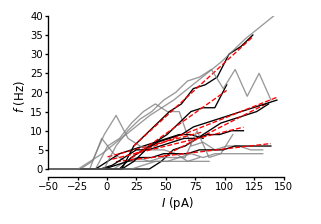

In [12]:
plt.figure()

curves = plt.subplot(111)
for i, curve in enumerate(fi_summaries):
    if curve.is_monotonic:
        curve.plot(fitted_pltargs={'color': 'r', 'ls': '--'}, ax=curves, color='k')
    else:
        curve.plot(fitted=False, ax=curves, color='grey', alpha=0.8)
    
curves.set_xlim(-50, 170)
curves.set_ylim(-2, 40)

curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only.svg'))

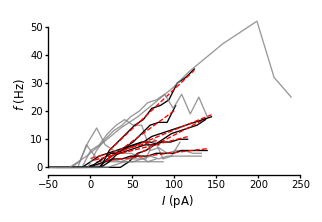

In [13]:
plt.figure()

curves = plt.subplot(111)
for i, curve in enumerate(fi_summaries):
    if curve.is_monotonic:
        curve.plot(fitted_pltargs={'color': 'r', 'ls': '--'}, ax=curves, color='k')
    else:
        curve.plot(fitted=False, ax=curves, color='grey', alpha=0.8)
    
curves.set_xlim(-50, curves.get_xlim()[1])

curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only_unscaled.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_fi_curve_only_unscaled.svg'))